In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
import re
import joblib

# Đọc dữ liệu dân tộc thiểu số

In [40]:
ethnic  = pd.read_excel('Datasets/Data_ethnic.xlsx')

In [41]:
ethnic

,Full_Names,Gender
0,Trần Ngọc Lan Anh,0
1,Nguyễn Thị Tú Anh,0
2,Trần Thị Kiêu Anh,0
3,Trần Thị Thanh Bình,0
4,Phạm Siêu Búp,1
...,...,...
3995,TRẦN QUANG LỘC,1
3996,NGUYỄN THỊ NGỌC VÂN,0
3997,TRẦN DƯƠNG NGỌC PHƯỢNG,0
3998,LAI DUY LONG,1


# Đọc dữ liệu dân tộc kinh

In [42]:
data = pd.read_csv('Datasets/UIT-ViNames.csv')

In [43]:
data

,Full_Names,Gender
0,Ngô Xuân Tùng,1
1,Bùi Dương Thảo Vy,0
2,Lưu Thế Huy,1
3,Nguyễn Thị Vân,0
4,Dương Minh Long,1
...,...,...
26846,Đoàn Thị Bảo Thu,0
26847,Ôn Hoa Thu,1
26848,Nguyễn Thị Huỳnh Như,0
26849,Nguyễn Thị Hồng Phúc,0


In [44]:
# Dữ liệu Tổng Hợp
df = pd.concat((data, ethnic), ignore_index=True)
df

,Full_Names,Gender
0,Ngô Xuân Tùng,1
1,Bùi Dương Thảo Vy,0
2,Lưu Thế Huy,1
3,Nguyễn Thị Vân,0
4,Dương Minh Long,1
...,...,...
30846,TRẦN QUANG LỘC,1
30847,NGUYỄN THỊ NGỌC VÂN,0
30848,TRẦN DƯƠNG NGỌC PHƯỢNG,0
30849,LAI DUY LONG,1


# Visualize data

Giới tính nữ: 13924 (45.13%)
Giới tính nam: 16927 (54.87%)
Điểm dữ liệu: 30851


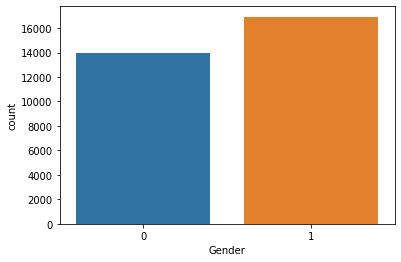

In [45]:
sns.countplot(data=df, x='Gender')
count_female = df[df.Gender==0].shape[0]
count_male = df[df.Gender==1].shape[0]
print(f'Giới tính nữ: {count_female} ({round(count_female/len(df) *100,2)}%)')
print(f'Giới tính nam: {count_male} ({round(count_male/len(df) *100,2)}%)')
print('Điểm dữ liệu:',len(df))

# Split data

In [46]:
# Step1: Tách ra 2 tập dữ liệu nam(data_female) và nữ(data_male) 
data_female = pd.concat((data[data['Gender']==0].reset_index(drop=True), ethnic[ethnic['Gender']==0].reset_index(drop=True)), axis=0, ignore_index=True)
data_male = pd.concat((data[data['Gender']==1].reset_index(drop=True), ethnic[ethnic['Gender']==1].reset_index(drop=True)), axis=0, ignore_index=True)

In [47]:
data_female

,Full_Names,Gender
0,Bùi Dương Thảo Vy,0
1,Nguyễn Thị Vân,0
2,Trần Mai Khanh,0
3,Nguyễn Thị Hồng Diệp,0
4,Nguyễn Mai Tường Vy,0
...,...,...
13919,BẾ THỊ HUỆ,0
13920,LÝ DIỆU HOÀNG,0
13921,NGUYỄN VIỆT HÀ,0
13922,NGUYỄN THỊ NGỌC VÂN,0


In [48]:
data_male

,Full_Names,Gender
0,Ngô Xuân Tùng,1
1,Lưu Thế Huy,1
2,Dương Minh Long,1
3,Nguyễn Hoàng Khang,1
4,Thi Ngọc Thái,1
...,...,...
16922,HÀ LONG THÀNH,1
16923,NGUYỄN THỊ CẨM LY,1
16924,TRẦN QUANG LỘC,1
16925,LAI DUY LONG,1


In [49]:
# Step2: Trên mỗi tập data_female và data_male ta dùng train_test_split để chia thành tập train, test theo tỉ lệ 7:3
from sklearn.model_selection import train_test_split
X_train_female, X_test_female, y_train_female, y_test_female = train_test_split(data_female['Full_Names'], data_female['Gender'], test_size=0.3, random_state=42)
X_train_male, X_test_male, y_train_male, y_test_male = train_test_split(data_male['Full_Names'], data_male['Gender'], test_size=0.3, random_state=42)

In [50]:
# Step3: Kết hợp mỗi tập dữ liệu của nam và nữ tương ứng với nhau ta được tập train, test
X_train = pd.concat((X_train_female, X_train_male), ignore_index=True)
X_test = pd.concat((X_test_female, X_test_male), ignore_index=True)
y_train = pd.concat((y_train_female, y_train_male), ignore_index=True)
y_test = pd.concat((y_test_female, y_test_male), ignore_index=True)

In [51]:
print(f'Số điểm dữ liệu tập train: {X_train.shape[0]}')
print(f'Số điểm dữ liệu tập test: {X_test.shape[0]}')

Số điểm dữ liệu tập train: 21594
Số điểm dữ liệu tập test: 9257


In [52]:
def Distribute_word(data, idx1, idx2):
    string_male, string_female = '', ''
    for row in range(len(data['Full_Names'])):
        word = data['Full_Names'][row].split()[idx1:idx2]
        for w in word:
            if data['Gender'][row] == 0:
                string_female += w + ' '
            else: string_male += w + ' ' 
            
    wordcloud_male = WordCloud(width = 500, height = 500, background_color ='white', collocations=False).generate(string_male)
    wordcloud_female = WordCloud(width = 500, height = 500, background_color ='white', collocations=False).generate(string_female)
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
    ax1.set_title('Male')
    ax1.imshow(wordcloud_male)
    
    ax2.set_title('Female')
    ax2.imshow(wordcloud_female)

    ax1.axis('off')
    ax2.axis('off')
    plt.show()

# The distribution male and female first names 

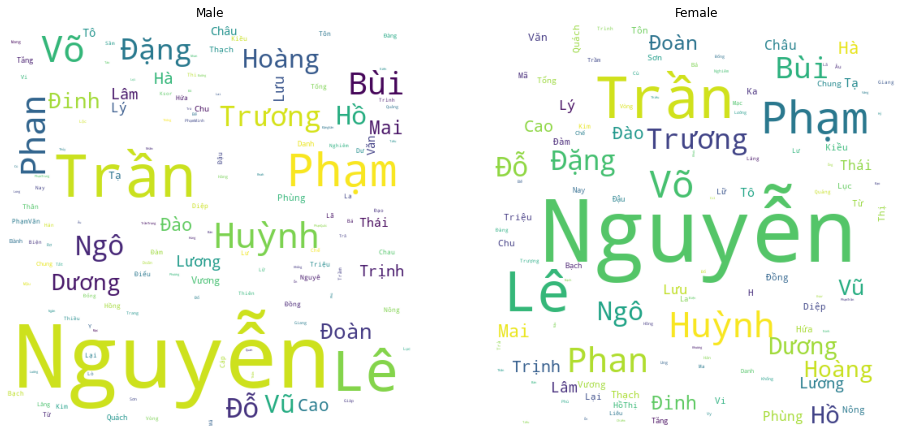

In [53]:
Distribute_word(data,0,1)

# The distribution of male and female middle names 

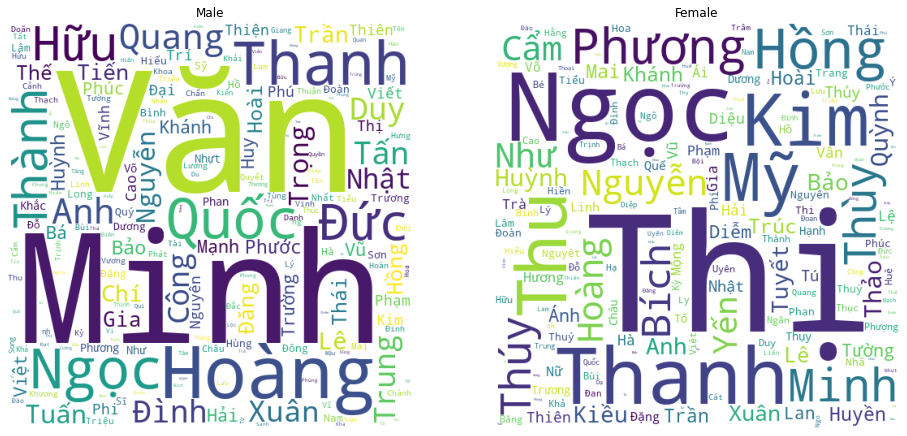

In [54]:
Distribute_word(data,1,-1)

# The distribution of male and female last names

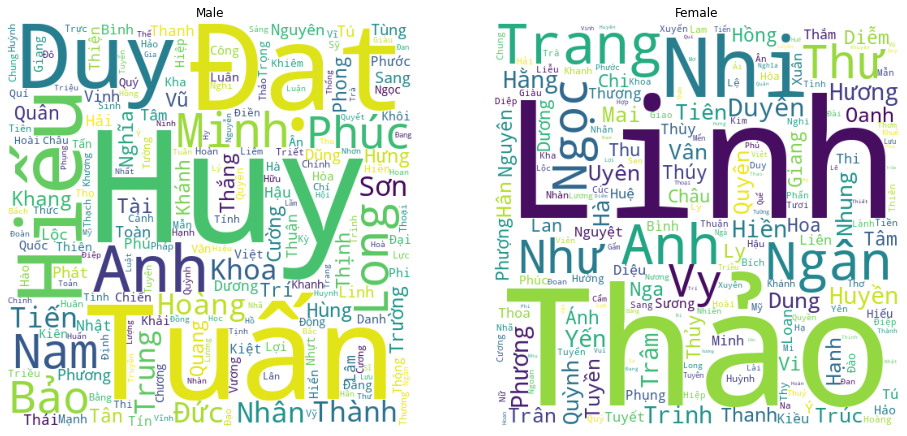

In [55]:
Distribute_word(data,-1,None)

# Preprocessing Data

In [56]:
def Preprocessing(name):
    
  # Xóa khoảng trắng thừa
  name = ' '.join(name.split())
  
  # Xóa các ký tự kéo dài: vd: Dũngggg -> Dũng
  name = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), name, flags=re.I)
  name = name.lower()

  # xóa ký tự đặc biệt vd Dũ@ng123 -> Dũng
  name = re.sub(r"[-()\\\"#/@;:<>{}`+=~|.!?,%/0123456789]", "", name)
  name = re.sub('\n', ' ', name)

  # Family Name(FaN): phạm lê trưởng -> phạm
  #name = name.split()[0]
  
  # Middle NAme (MN): phạm lê trưởng -> lê
  #name = ' '.join(name.split()[1:-1])

  # First Name (FiN): phạm lê trưởng -> trưởng
  #name = name.split()[-1]
  
  # FaN + MN: phạm lê trưởng -> phạm lê
  #name = ' '.join(name.split()[:-1])
  
  # FaN + FiN: phạm lê trưởng -> phạm trưởng
  #name = ' '.join([name.split()[0], name.split()[-1]])
  
  # MN + FiN: phạm lê trưởng -> lê trưởng
  #name = ' '.join(name.split()[1:])
  
  # FaN + MN + FiN: phạm lê trưởng -> phạm lê trưởng
  name = name

  return name

In [57]:
# preprocessing for training set
for i in tqdm(range(len(X_train))):
    X_train[i] = Preprocessing(X_train[i])

100%|██████████| 21594/21594 [00:00<00:00, 49917.33it/s]


In [58]:
# preprocessing for test set
X_test_original = pd.Series.copy(X_test)
for i in tqdm(range(len(X_test))):
    X_test[i] = Preprocessing(X_test[i])
    

100%|██████████| 9257/9257 [00:00<00:00, 46681.60it/s]


In [59]:
X_train

0               nguyễn ngọc hân
1            đoàn thị hồng loan
2             nguyễn thị vũ thư
3        nguyễn hồng thanh trúc
4                    hạc hà anh
                  ...          
21589             trần duy nhất
21590             trần ngọc tấn
21591            trần quốc tuấn
21592       tạ phạm minh chương
21593       nguyễn trường giang
Name: Full_Names, Length: 21594, dtype: object

In [60]:
X_test

0              tao thị lương
1              phan thị linh
2                 trần lệ hà
3          hà thị thanh thủy
4       nguyễn thị thu trang
                ...         
9252       thạch phương vinh
9253         lê trung nguyên
9254         nguyễn phúc tâm
9255          trịnh minh tâm
9256           phạm thuận an
Name: Full_Names, Length: 9257, dtype: object

# Use CountVectorizer to encode data

In [61]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [62]:
X_train_cv.shape

(21594, 1747)

# Use TfidfVectorizer to encode data

In [63]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [64]:
def Train_model(model, option):
    if option==1:
        model.fit(X_train_cv, y_train)
        y_pred = model.predict(X_test_cv)
    else: 
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_test_tfidf)
    return y_pred
        

In [65]:
def Plot_confusion_matrix(model_cv, model_tfidf, model_name):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,5))
    plot_confusion_matrix(model_cv, X_test_cv, y_test, ax=ax1,cmap='Blues')
    ax1.title.set_text(f'Count Vector + {model_name}')
    plot_confusion_matrix(model_tfidf, X_test_tfidf, y_test, ax=ax2,cmap='Blues')
    ax2.title.set_text(f'TF-IDF + {model_name}')

In [66]:
def Eval_model(y_test, y_pred):
    
    cls_report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred, digits=4))
    print(f"\tAccuracy: {cls_report['accuracy']}")
    print(f"\tPrecision: {cls_report['macro avg']['precision']}")
    print(f"\tRecall: {cls_report['macro avg']['recall']}")
    print(f"\tF1_score for female: {cls_report['0']['f1-score']}")
    print(f"\tF1_score for male: {cls_report['1']['f1-score']}")
    print(f"\tF1_score average: {cls_report['macro avg']['f1-score']}")
    
    return cls_report['0']['f1-score'], cls_report['1']['f1-score'], cls_report['macro avg']['f1-score']
    

# Naive Bayes model

In [67]:
from sklearn.naive_bayes import MultinomialNB

In [68]:
NB_model_cv , NB_model_tfidf = MultinomialNB(), MultinomialNB()

In [69]:
NB_model_cv , NB_model_tfidf = MultinomialNB(), MultinomialNB()
y_pred_cv = Train_model(NB_model_cv, option=1)
y_pred_tfidf = Train_model(NB_model_tfidf, option=2)

In [70]:
# Measure of 6 algorithms: 
# F1_cv_Female	F1_cv_Male	F1_cv_Average	F1_tfidf_Female	 F1_tfidf_Male	F1_tfidf_Average
measure = [[0,0,0,0,0,0]]*6

In [71]:
print('NAIVE BAYES MODEL: MEASURES WITH THE ENCODER COUNTVECTORIZER')
f1_cv_0, f1_cv_1, f1_cv_avg = Eval_model(y_test, y_pred_cv)

print('NAIVE BAYES MODEL: MEASURES WITH THE ENCODER TFIDFVECTORIZER')
f1_tfidf_0, f1_tfidf_1, f1_tfidf_avg = Eval_model(y_test, y_pred_tfidf)

measure[0] = [f1_cv_0, f1_cv_1, f1_cv_avg, f1_tfidf_0, f1_tfidf_1, f1_tfidf_avg]

NAIVE BAYES MODEL: MEASURES WITH THE ENCODER COUNTVECTORIZER
              precision    recall  f1-score   support

           0     0.9404    0.9409    0.9407      4178
           1     0.9513    0.9510    0.9512      5079

    accuracy                         0.9464      9257
   macro avg     0.9459    0.9459    0.9459      9257
weighted avg     0.9464    0.9464    0.9464      9257

	Accuracy: 0.9464189262179972
	Precision: 0.9458899219955272
	Recall: 0.9459277027560051
	F1_score for female: 0.9406556592486242
	F1_score for male: 0.9511618747538401
	F1_score average: 0.945908767001232
NAIVE BAYES MODEL: MEASURES WITH THE ENCODER TFIDFVECTORIZER
              precision    recall  f1-score   support

           0     0.9318    0.9256    0.9287      4178
           1     0.9391    0.9443    0.9417      5079

    accuracy                         0.9358      9257
   macro avg     0.9355    0.9349    0.9352      9257
weighted avg     0.9358    0.9358    0.9358      9257

	Accuracy: 0.93583

c:\Users\DELL\anaconda3\envs\streamlit\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\DELL\anaconda3\envs\streamlit\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


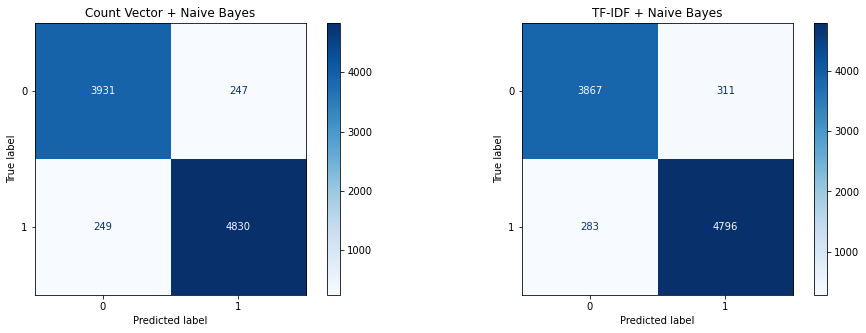

In [72]:
Plot_confusion_matrix(NB_model_cv, NB_model_tfidf, model_name='Naive Bayes')

# Mô hình SVM


In [73]:
from sklearn.svm import SVC

In [74]:
SVM_model_cv, SVM_model_tfidf = SVC(), SVC()
y_pred_cv = Train_model(SVM_model_cv, option=1)
y_pred_tfidf = Train_model(SVM_model_tfidf, option=2)

In [75]:
print('SVM MODEL: MEASURES WITH THE ENCODER COUNTVECTORIZER')
f1_cv_0, f1_cv_1, f1_cv_avg = Eval_model(y_test, y_pred_cv)

print('SVM MODEL: MEASURES WITH THE ENCODER TFIDFVECTORIZER')
f1_tfidf_0, f1_tfidf_1, f1_tfidf_avg = Eval_model(y_test, y_pred_tfidf)

measure[1] = [f1_cv_0, f1_cv_1, f1_cv_avg, f1_tfidf_0, f1_tfidf_1, f1_tfidf_avg]

SVM MODEL: MEASURES WITH THE ENCODER COUNTVECTORIZER
              precision    recall  f1-score   support

           0     0.9692    0.9251    0.9466      4178
           1     0.9406    0.9758    0.9579      5079

    accuracy                         0.9529      9257
   macro avg     0.9549    0.9504    0.9522      9257
weighted avg     0.9535    0.9529    0.9528      9257

	Accuracy: 0.9529005077238847
	Precision: 0.9548767054627538
	Recall: 0.9504332032583128
	F1_score for female: 0.94660788635807
	F1_score for male: 0.9578662543486665
	F1_score average: 0.9522370703533682
SVM MODEL: MEASURES WITH THE ENCODER TFIDFVECTORIZER
              precision    recall  f1-score   support

           0     0.9646    0.9253    0.9445      4178
           1     0.9406    0.9720    0.9560      5079

    accuracy                         0.9510      9257
   macro avg     0.9526    0.9487    0.9503      9257
weighted avg     0.9514    0.9510    0.9509      9257

	Accuracy: 0.9509560332721184
	Prec

c:\Users\DELL\anaconda3\envs\streamlit\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\DELL\anaconda3\envs\streamlit\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


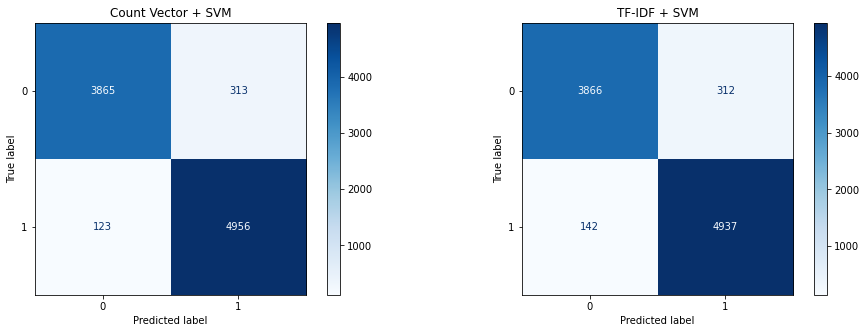

In [76]:
Plot_confusion_matrix(SVM_model_cv, SVM_model_tfidf, model_name='SVM')

# Logistic regression model

In [77]:
from sklearn.linear_model import LogisticRegression

In [78]:
LR_model_cv, LR_model_tfidf = LogisticRegression(), LogisticRegression()
y_pred_cv = Train_model(LR_model_cv, option=1)
y_pred_tfidf = Train_model(LR_model_tfidf, option=2)

In [79]:
print('LOGISTIC REGRESSION MODEL: MEASURES WITH THE ENCODER COUNTVECTORIZER')
f1_cv_0, f1_cv_1, f1_cv_avg = Eval_model(y_test, y_pred_cv)

print('LOGISTIC REGRESSION MODEL: MEASURES WITH THE ENCODER TFIDFVECTORIZER')
f1_tfidf_0, f1_tfidf_1, f1_tfidf_avg = Eval_model(y_test, y_pred_tfidf)

measure[2] = [f1_cv_0, f1_cv_1, f1_cv_avg, f1_tfidf_0, f1_tfidf_1, f1_tfidf_avg]

LOGISTIC REGRESSION MODEL: MEASURES WITH THE ENCODER COUNTVECTORIZER
              precision    recall  f1-score   support

           0     0.9656    0.9260    0.9454      4178
           1     0.9411    0.9728    0.9567      5079

    accuracy                         0.9517      9257
   macro avg     0.9534    0.9494    0.9511      9257
weighted avg     0.9522    0.9517    0.9516      9257

	Accuracy: 0.9517122177811386
	Precision: 0.9533515633355913
	Recall: 0.9494352325643536
	F1_score for female: 0.9453879047037265
	F1_score for male: 0.9567237873947141
	F1_score average: 0.9510558460492202
LOGISTIC REGRESSION MODEL: MEASURES WITH THE ENCODER TFIDFVECTORIZER
              precision    recall  f1-score   support

           0     0.9644    0.9215    0.9425      4178
           1     0.9377    0.9720    0.9546      5079

    accuracy                         0.9492      9257
   macro avg     0.9511    0.9468    0.9485      9257
weighted avg     0.9498    0.9492    0.9491      9257

	

c:\Users\DELL\anaconda3\envs\streamlit\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\DELL\anaconda3\envs\streamlit\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


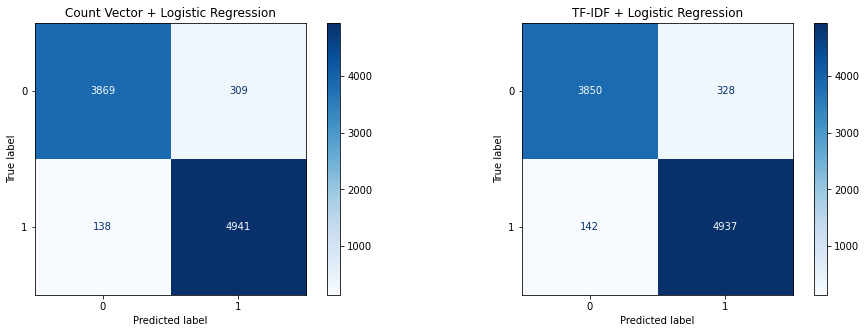

In [80]:
Plot_confusion_matrix(LR_model_cv, LR_model_tfidf, model_name='Logistic Regression')

# Mô hình KNN

In [81]:
from sklearn.neighbors import KNeighborsClassifier

In [82]:
KNN_model_cv, KNN_model_tfidf = KNeighborsClassifier(), KNeighborsClassifier()
y_pred_cv = Train_model(KNN_model_cv, option=1)
y_pred_tfidf = Train_model(KNN_model_tfidf, option=2)

In [83]:
print('KNN MODEL: MEASURES WITH THE ENCODER COUNTVECTORIZER')
f1_cv_0, f1_cv_1, f1_cv_avg = Eval_model(y_test, y_pred_cv)

print('KNN MODEL: MEASURES WITH THE ENCODER TFIDFVECTORIZER')
f1_tfidf_0, f1_tfidf_1, f1_tfidf_avg = Eval_model(y_test, y_pred_tfidf)

measure[3] = [f1_cv_0, f1_cv_1, f1_cv_avg, f1_tfidf_0, f1_tfidf_1, f1_tfidf_avg]

KNN MODEL: MEASURES WITH THE ENCODER COUNTVECTORIZER
              precision    recall  f1-score   support

           0     0.9509    0.8760    0.9119      4178
           1     0.9042    0.9628    0.9326      5079

    accuracy                         0.9236      9257
   macro avg     0.9276    0.9194    0.9223      9257
weighted avg     0.9253    0.9236    0.9233      9257

	Accuracy: 0.9236253645889597
	Precision: 0.9275561565210975
	Recall: 0.9194025917549157
	F1_score for female: 0.9119222623645197
	F1_score for male: 0.9325831982454469
	F1_score average: 0.9222527303049832
KNN MODEL: MEASURES WITH THE ENCODER TFIDFVECTORIZER
              precision    recall  f1-score   support

           0     0.8927    0.8997    0.8962      4178
           1     0.9170    0.9110    0.9140      5079

    accuracy                         0.9059      9257
   macro avg     0.9048    0.9054    0.9051      9257
weighted avg     0.9060    0.9059    0.9059      9257

	Accuracy: 0.9059090418062007
	Pr

c:\Users\DELL\anaconda3\envs\streamlit\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\DELL\anaconda3\envs\streamlit\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


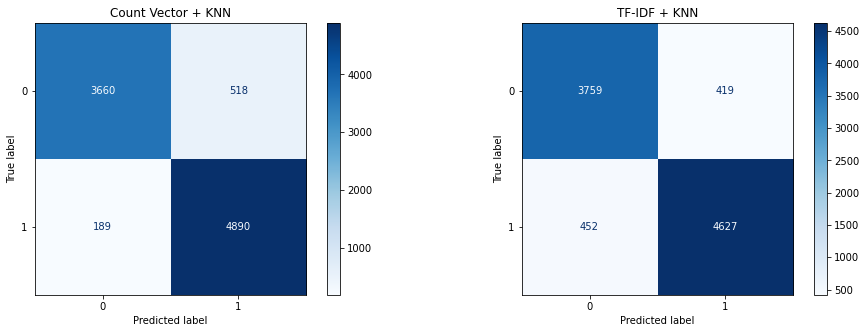

In [84]:
Plot_confusion_matrix(KNN_model_cv, KNN_model_tfidf, model_name='KNN')

# Decision Tree

In [85]:
from sklearn.tree import DecisionTreeClassifier

In [86]:
DT_model_cv, DT_model_tfidf = DecisionTreeClassifier(random_state=0), DecisionTreeClassifier(random_state=0)
y_pred_cv = Train_model(DT_model_cv, option=1)
y_pred_tfidf = Train_model(DT_model_tfidf, option=2)

In [87]:
print('DECISION TREE MODEL: MEASURES WITH THE ENCODER COUNTVECTORIZER')
f1_cv_0, f1_cv_1, f1_cv_avg = Eval_model(y_test, y_pred_cv)

print('DECISION TREE MODEL: MEASURES WITH THE ENCODER TFIDFVECTORIZER')
f1_tfidf_0, f1_tfidf_1, f1_tfidf_avg = Eval_model(y_test, y_pred_tfidf)

measure[4] = [f1_cv_0, f1_cv_1, f1_cv_avg, f1_tfidf_0, f1_tfidf_1, f1_tfidf_avg]

DECISION TREE MODEL: MEASURES WITH THE ENCODER COUNTVECTORIZER
              precision    recall  f1-score   support

           0     0.9269    0.9076    0.9172      4178
           1     0.9253    0.9411    0.9331      5079

    accuracy                         0.9260      9257
   macro avg     0.9261    0.9244    0.9251      9257
weighted avg     0.9260    0.9260    0.9259      9257

	Accuracy: 0.9260019444744517
	Precision: 0.9260967083253959
	Recall: 0.9243707205002512
	F1_score for female: 0.9171604788970855
	F1_score for male: 0.9331381161542216
	F1_score average: 0.9251492975256536
DECISION TREE MODEL: MEASURES WITH THE ENCODER TFIDFVECTORIZER
              precision    recall  f1-score   support

           0     0.9152    0.9093    0.9122      4178
           1     0.9258    0.9307    0.9282      5079

    accuracy                         0.9210      9257
   macro avg     0.9205    0.9200    0.9202      9257
weighted avg     0.9210    0.9210    0.9210      9257

	Accuracy: 0.

c:\Users\DELL\anaconda3\envs\streamlit\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\DELL\anaconda3\envs\streamlit\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


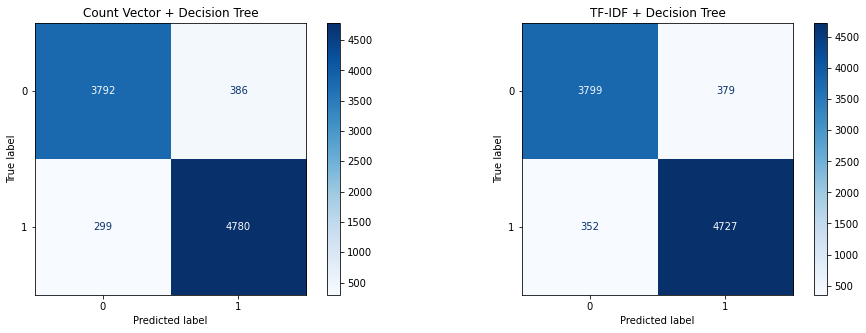

In [88]:
Plot_confusion_matrix(DT_model_cv, DT_model_tfidf, model_name='Decision Tree')

# Random Forest

In [89]:
from sklearn.ensemble import RandomForestClassifier

In [90]:
RF_model_cv, RF_model_tfidf = RandomForestClassifier(random_state=0), RandomForestClassifier(random_state=0)
y_pred_cv = Train_model(RF_model_cv, option=1)
y_pred_tfidf = Train_model(RF_model_tfidf, option=2)

In [91]:
print('RANDOM FOREST MODEL: MEASURES WITH THE ENCODER COUNTVECTORIZER')
f1_cv_0, f1_cv_1, f1_cv_avg = Eval_model(y_test, y_pred_cv)

print('RANDOM FOREST MODEL: MEASURES WITH THE ENCODER TFIDFVECTORIZER')
f1_tfidf_0, f1_tfidf_1, f1_tfidf_avg = Eval_model(y_test, y_pred_tfidf)

measure[5] = [f1_cv_0, f1_cv_1, f1_cv_avg, f1_tfidf_0, f1_tfidf_1, f1_tfidf_avg]

RANDOM FOREST MODEL: MEASURES WITH THE ENCODER COUNTVECTORIZER
              precision    recall  f1-score   support

           0     0.9571    0.9236    0.9401      4178
           1     0.9389    0.9659    0.9523      5079

    accuracy                         0.9469      9257
   macro avg     0.9480    0.9448    0.9462      9257
weighted avg     0.9471    0.9469    0.9468      9257

	Accuracy: 0.946851031651723
	Precision: 0.9480203111946532
	Recall: 0.9447929275607206
	F1_score for female: 0.9400730816077953
	F1_score for male: 0.952251552795031
	F1_score average: 0.9461623172014132
RANDOM FOREST MODEL: MEASURES WITH THE ENCODER TFIDFVECTORIZER
              precision    recall  f1-score   support

           0     0.9480    0.9292    0.9385      4178
           1     0.9427    0.9581    0.9503      5079

    accuracy                         0.9450      9257
   macro avg     0.9453    0.9436    0.9444      9257
weighted avg     0.9451    0.9450    0.9450      9257

	Accuracy: 0.94

c:\Users\DELL\anaconda3\envs\streamlit\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\DELL\anaconda3\envs\streamlit\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


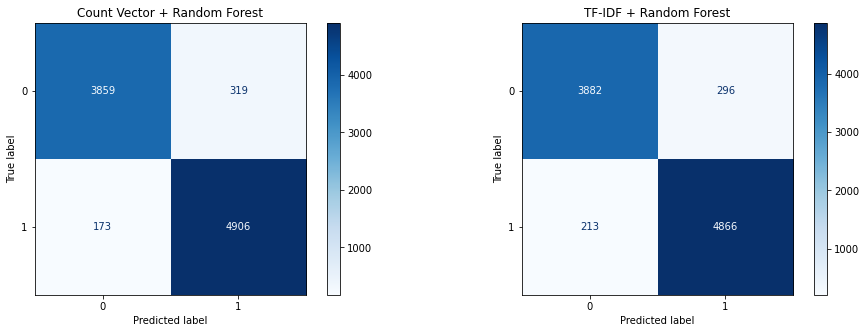

In [92]:
Plot_confusion_matrix(RF_model_cv, RF_model_tfidf, model_name='Random Forest')

In [93]:
columns = ['F1_cv_Female', 'F1_cv_Male', 'F1_cv_Average', 'F1_tfidf_Female', 'F1_tfidf_Male', 'F1_tfidf_Average']
algorithm = ['Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'K-Nearest Neighbors', 'Decision Tree', 'RandomForest']
pd.DataFrame(measure, columns=columns, index=algorithm)

,F1_cv_Female,F1_cv_Male,F1_cv_Average,F1_tfidf_Female,F1_tfidf_Male,F1_tfidf_Average
Naive Bayes,0.940656,0.951162,0.945909,0.928674,0.941685,0.935180
Support Vector Machine,0.946608,0.957866,0.952237,0.944539,0.956042,0.950291
Logistic Regression,0.945388,0.956724,0.951056,0.942472,0.954563,0.948518
K-Nearest Neighbors,0.911922,0.932583,0.922253,0.896174,0.913975,0.905074
Decision Tree,0.917160,0.933138,0.925149,0.912234,0.928228,0.920231
RandomForest,0.940073,0.952252,0.946162,0.938475,0.950298,0.944386


Nhận xét thấy 3 model Naive Bayes, SVM, Logistic Regression cho kết quả F1-score tốt nhất khi encoding dùng CountVectorizer

sử dụng VotingClassifier trên 3 model này để tối ưu f1_score

In [94]:
from sklearn.ensemble import VotingClassifier
SVM_model_cv.probability=True
SVM_model_tfidf.probability=True
voting_clf_cv = VotingClassifier(estimators=[('nb',NB_model_cv),('lr',LR_model_cv),('svm',SVM_model_cv)], voting='soft',weights=[1,2,3])
voting_clf_tfidf = VotingClassifier(estimators=[('nb',NB_model_tfidf),('lr',LR_model_tfidf),('svm',SVM_model_tfidf)], voting='soft',weights=[1,2,3])

print('Using CountVectorizer:')
for clf in [NB_model_cv,LR_model_cv,SVM_model_cv,voting_clf_cv]:
    clf.fit(X_train_cv, y_train)
    y_pred=clf.predict(X_test_cv)
    print('\t',clf.__class__.__name__,f1_score(y_test,y_pred, average='macro'))

print('\nUsing TfidfVectorizer:')
for clf in [NB_model_tfidf,LR_model_tfidf,SVM_model_tfidf,voting_clf_tfidf]:
    clf.fit(X_train_tfidf, y_train)
    y_pred=clf.predict(X_test_tfidf)
    print('\t',clf.__class__.__name__,f1_score(y_test,y_pred, average='macro'))

Using CountVectorizer:
	 MultinomialNB 0.945908767001232
	 LogisticRegression 0.9510558460492202
	 SVC 0.9522370703533682
	 VotingClassifier 0.9556878664510562

Using TfidfVectorizer:
	 MultinomialNB 0.9351795084058981
	 LogisticRegression 0.9485177459647607
	 SVC 0.9502906428254168
	 VotingClassifier 0.9516526279947624


# Save All Model

In [95]:
joblib.dump(NB_model_cv, 'NB_model_cv.h5')
joblib.dump(NB_model_tfidf, 'NB_model_tfidf.h5')

joblib.dump(LR_model_cv, 'LR_model_cv.h5')
joblib.dump(LR_model_tfidf, 'LR_model_tfidf.h5')

joblib.dump(SVM_model_cv, 'SVM_model_cv.h5')
joblib.dump(SVM_model_tfidf, 'SVM_model_tfidf.h5')

joblib.dump(KNN_model_cv, 'KNN_model_cv.h5')
joblib.dump(KNN_model_tfidf, 'KNN_model_tfidf.h5')

joblib.dump(DT_model_cv, 'DT_model_cv.h5')
joblib.dump(DT_model_tfidf, 'DT_model_tfidf.h5')

joblib.dump(RF_model_cv, 'RF_model_cv.h5')
joblib.dump(RF_model_tfidf, 'RF_model_tfidf.h5')

joblib.dump(voting_clf_cv, 'Voting_clf_cv.h5')
joblib.dump(voting_clf_tfidf, 'Voting_clf_tfidf.h5')


['Voting_clf_tfidf.h5']

In [96]:
# Dùng voting_clf để dự đoán mô hình
y_pred_cv = voting_clf_cv.predict(X_test_cv)

In [97]:
# Kết quả dự đoán trên tập test
Result = pd.concat((X_test_original, y_test, pd.DataFrame(y_pred_cv, columns=['Gender_Predict'])), axis=1)
Result

,Full_Names,Gender,Gender_Predict
0,Tao Thị Lương,0,0
1,Phan Thị Linh,0,0
2,Trần Lệ Hà,0,0
3,Hà Thị Thanh Thủy,0,0
4,Nguyễn Thị Thu Trang,0,0
...,...,...,...
9252,Thạch Phương Vinh,1,1
9253,Lê Trung Nguyên,1,1
9254,Nguyễn Phúc Tâm,1,1
9255,Trịnh Minh Tâm,1,1


In [98]:
Wrong_Pred = pd.DataFrame()
name, gender, gender_pred = [], [], []
for i in range(len(Result)):
    if Result['Gender'][i] != Result['Gender_Predict'][i]:
        name.append(Result['Full_Names'][i])
        gender.append(Result['Gender'][i])
        gender_pred.append(Result['Gender_Predict'][i])
Wrong_Pred['Full_Names'] = name
Wrong_Pred['Gender'] = gender
Wrong_Pred['Gender_Predict'] = gender_pred

In [99]:
# Danh sách tên nam nhưng dự đoán là nữ
Wrong_Pred[Wrong_Pred['Gender']==1].reset_index(drop=True)

,Full_Names,Gender,Gender_Predict
0,Lê Yến Thanh,1,0
1,Nguyễn Thị Tuyến,1,0
2,Phạm Thị Kim Phượng,1,0
3,Lâm Thị Mỹ Huyền,1,0
4,Trần Châu Giang,1,0
...,...,...,...
127,Trần Liên Thanh,1,0
128,Đỗ Thị Liên,1,0
129,Nguyễn Trà Vi,1,0
130,THẠCH THỊ MỸ LỘC,1,0


In [100]:
# Danh sách tên nữ nhưng dự đoán là nam
Wrong_Pred[Wrong_Pred['Gender']==0].reset_index(drop=True)

,Full_Names,Gender,Gender_Predict
0,Lê Hoài Nguyên,0,1
1,Đoàn Bảo Lộc,0,1
2,Hứa Ngọc Thuận,0,1
3,Trần An Hải,0,1
4,Trương Thanh Tâm,0,1
...,...,...,...
268,H Sara Hra,0,1
269,Huỳnh Trần Phú,0,1
270,Lê Cát Tường,0,1
271,PhạmHuỳnh Giao,0,1
